In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Optional, for visualization later

# Load the specific CSV file
filename = 'final_filtered_median_data.csv'

try:
    df = pd.read_csv(filename)
    print(f"Successfully loaded '{filename}' with {len(df)} rows.")
    
    # Quick check to ensure columns match expectations
    expected_cols = ['names', 'country', 'lat', 'lon', 'years', 'sea_level_change']
    if not all(col in df.columns for col in expected_cols):
        print(f"Warning: Columns do not match exactly. Found: {df.columns.tolist()}")
    else:
        print("Column names verified.")
        
    # display(df.head()) # Uncomment to see the first few rows

except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found in the current directory.")

Successfully loaded 'final_filtered_median_data.csv' with 1400 rows.
Column names verified.


In [3]:
def extrapolate_sea_level(input_df, start_year=2160, end_year=2500, interval=10):
    future_data_list = []

    # Group by the constant columns so we process one location at a time
    # This ensures 'City A' data doesn't mix with 'City B'
    grouped = input_df.groupby(['names', 'country', 'lat', 'lon'])

    for (name, country, lat, lon), group in grouped:
        # Sort by year just to be safe before fitting
        group = group.sort_values('years')
        
        X = group['years'].values
        y = group['sea_level_change'].values

        # Fit a 2nd degree polynomial: y = ax^2 + bx + c
        # This captures the acceleration curve common in sea level rise
        if len(X) > 1:
            z = np.polyfit(X, y, 2)
            p = np.poly1d(z)
        else:
            # Fallback: if only 1 point exists, keep value constant
            p = lambda x: y[0]

        # Generate the new timeline
        future_years = np.arange(start_year, end_year + interval, interval)
        
        # Calculate predicted values
        predicted_values = p(future_years)

        # Structure the data for the new rows
        for yr, val in zip(future_years, predicted_values):
            future_data_list.append({
                'names': name,
                'country': country,
                'lat': lat,
                'lon': lon,
                'years': yr,
                'sea_level_change': val
            })

    return pd.DataFrame(future_data_list)

In [4]:
# 1. Generate the synthetic data for 2160 - 2500
print("Generating synthetic data... this may take a moment depending on file size.")
df_synthetic = extrapolate_sea_level(df)

# 2. Combine original and synthetic data
df_final = pd.concat([df, df_synthetic], ignore_index=True)

# 3. Sort for cleanliness (by Location, then by Year)
df_final = df_final.sort_values(by=['names', 'country', 'years'])

print(f"Process Complete.")
print(f"Original Row Count: {len(df)}")
print(f"New Row Count:      {len(df_final)}")

Generating synthetic data... this may take a moment depending on file size.
Process Complete.
Original Row Count: 1400
New Row Count:      4900


In [5]:
output_filename = 'extended_sea_level_data_2500.csv'

# Save to CSV (index=False removes the pandas row numbers)
df_final.to_csv(output_filename, index=False)

print(f"File saved successfully as: {output_filename}")

File saved successfully as: extended_sea_level_data_2500.csv


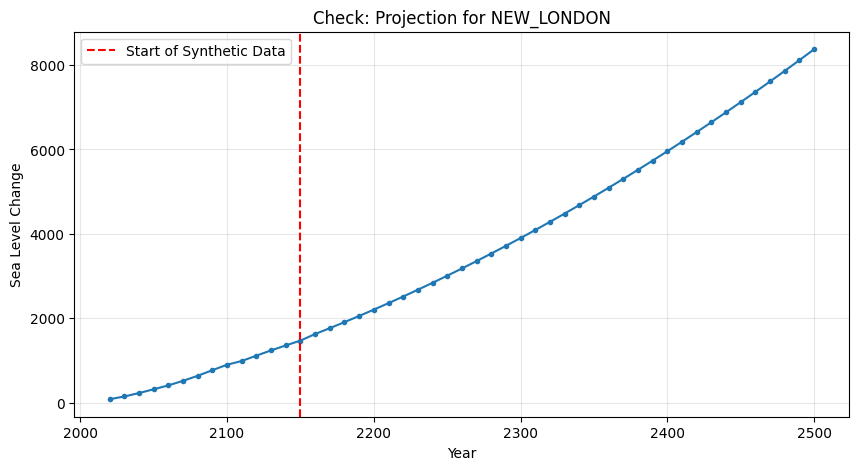

In [11]:
# Pick one random city from the dataset to visualize
random_city = df_final['names'].sample(1).values[0]
subset = df_final[df_final['names'] == random_city]

plt.figure(figsize=(10, 5))
plt.plot(subset['years'], subset['sea_level_change'], marker='.', linestyle='-')
plt.axvline(x=2150, color='red', linestyle='--', label='Start of Synthetic Data')
plt.title(f"Check: Projection for {random_city}")
plt.xlabel("Year")
plt.ylabel("Sea Level Change")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()